In [1]:
import warnings
warnings.filterwarnings('ignore')
# Hide input cells in Jupyter Notebook
from IPython.display import display, HTML

display(HTML("<style>.jp-InputArea { display: None !important; }</style>"))


In [2]:
import numpy as np
import pandas as pd
import glob

# import all csv files and concatenate them into one dataframe
path = '/home/shiftpub/Dynamic_AMM/results/dummy_results/'
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)




| **Parameter**            | **Value**                                                                 |
|--------------------------|---------------------------------------------------------------------------|
| **Initial Token A**       | 1,000,000 units (1 million)                                               |
| **Initial Token B**       | 1,000,000 units (1 million)                                               |
| **Fee Rate**              | `np.round(np.arange(0.0005, 0.02, 0.0005), 4)`  |
| **Sigma (Volatility)**    | `np.round(np.arange(0.05, 0.35, 0.05), 3)`  |
| **Time Interval (dt)**    | `1/(252*6.5*3600)` (second interval)                                      |
| **Simulation Length**     | 468,000 steps (20 trading days)                                                      |
| **Market Spread**         | 0.05                                                                     |
| **Drift Rate**            | 0.06                                                                   |
| **Start Price (Token A, B)** | 500                                                                 |
| **Iterations per Combination** | 300 (for each combination of `sigma` and `fee rate`)                |



### Plan:

    I. Demonstrate the overall relationship between sigmas and fee collected in AMM.

    II. Explore the Max Mean fee rate for each sigma.

    III. Examine the pattern between sigma and Max Mean fee rate. 



In [3]:
df1 = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined.csv')
df2 = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined2.csv')

In [17]:
results = pd.concat([df1, df2], axis=0, ignore_index=True)
results.sort_values(by=['sigma'], inplace=True)
print(results.shape)
print(results.columns)

(2700000, 11)
Index(['fee_rate', 'sigma', 'total_pnl', 'total_fee', 'total_vol',
       'impermanent_loss', 'net_profit', 'amm_lr', 'amm_ls', 'mkt_r', 'mkt_s'],
      dtype='object')


[0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325
 0.35  0.375 0.4  ]


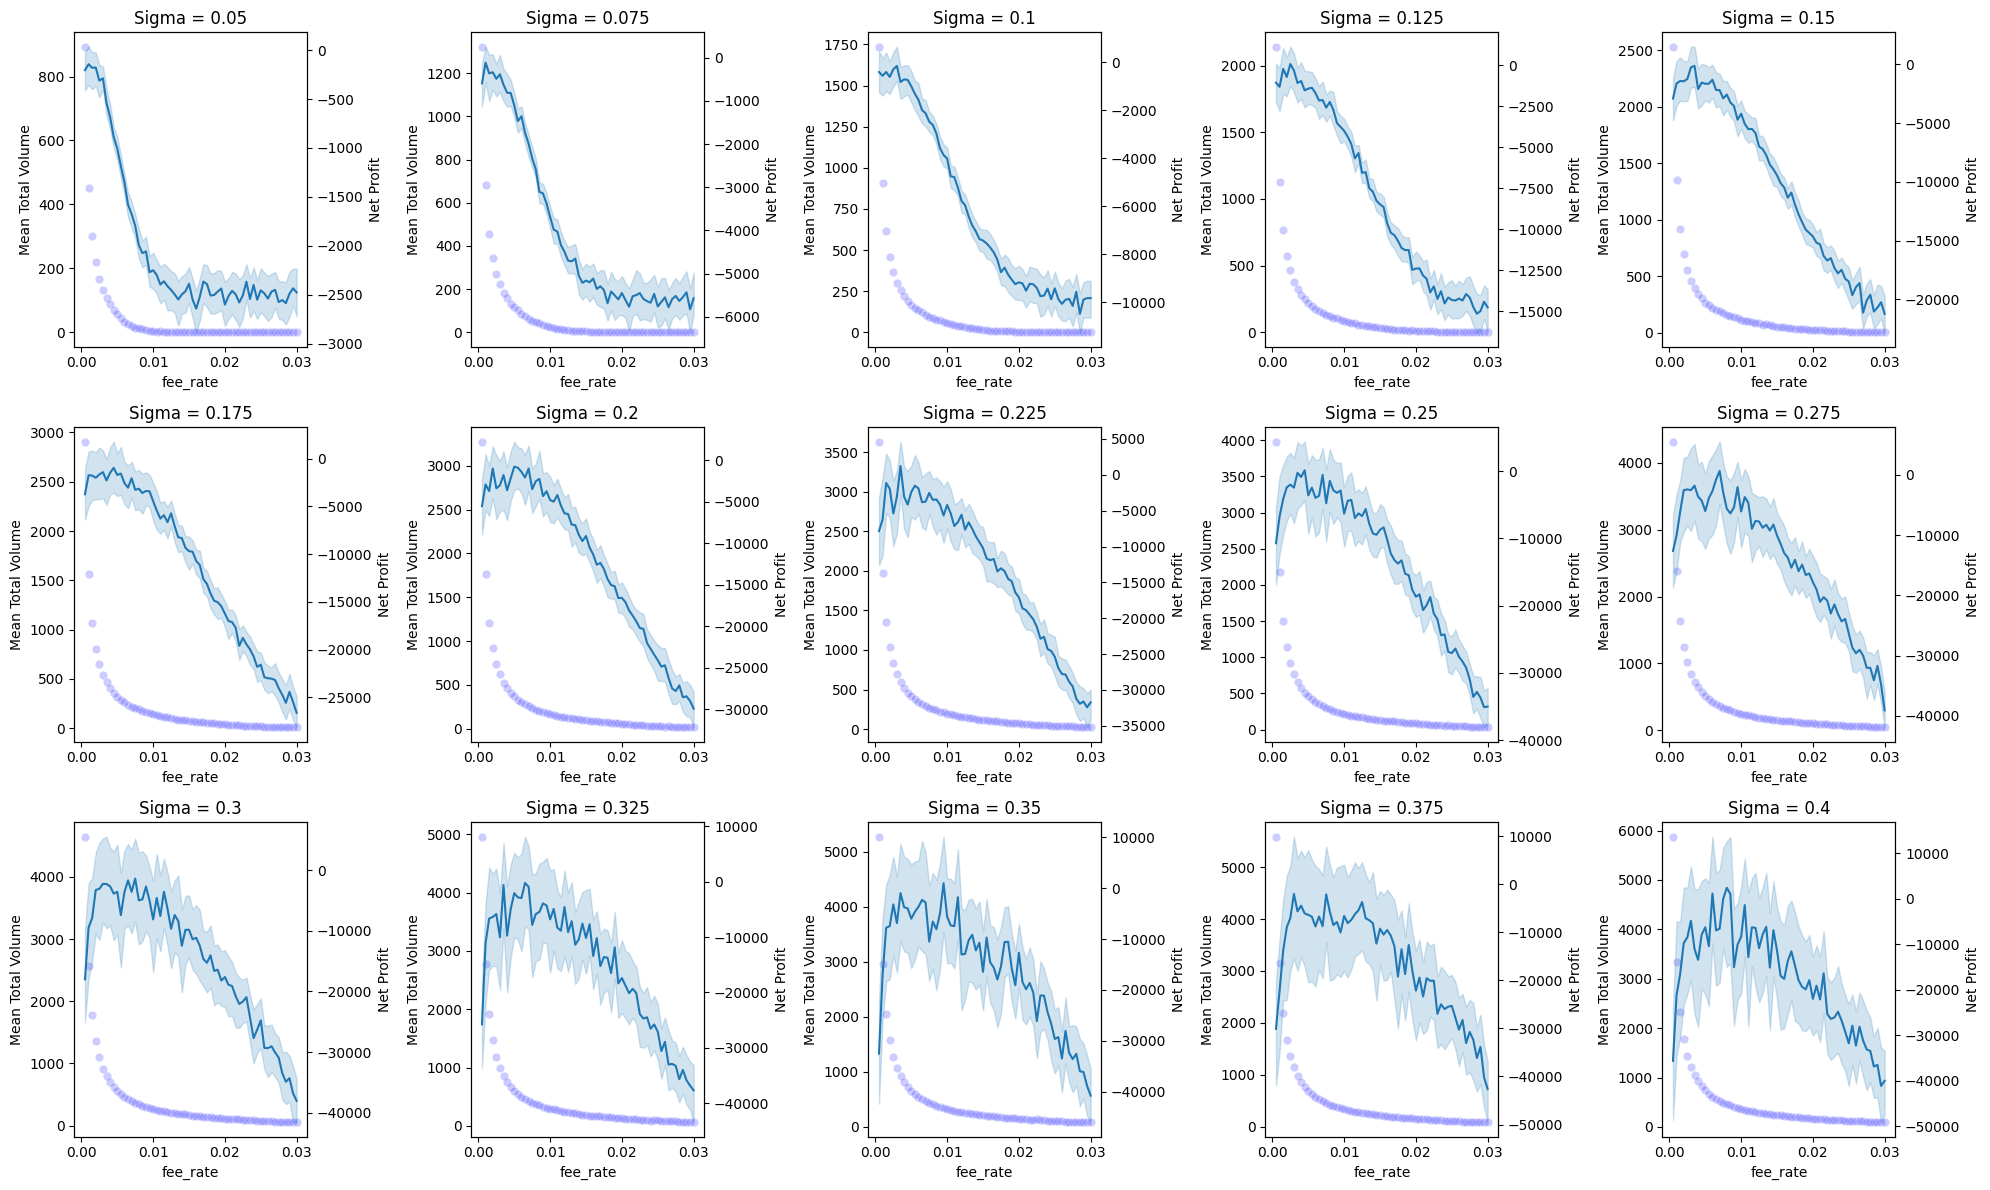

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unique sigma values
sigma_values = results.sigma.unique()
print(sigma_values)

# Create a 3x5 grid for the subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Adjust figure size as needed

for i, sigma in enumerate(sigma_values):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    
    # Filter data for the current sigma
    df = results[results.sigma == sigma]
    # Group by fee_rate and calculate the mean of net_profit and total_vol
    grouped_df = df.groupby('fee_rate').agg({'net_profit': 'mean', 'total_vol': 'mean'}).reset_index()
    max_fee_rate = grouped_df.loc[grouped_df.net_profit.idxmax(), 'fee_rate']
    
    # Plot net profit as a line plot on the primary y-axis
    sns.scatterplot(x='fee_rate', y='total_vol', data=grouped_df, ax=ax, color='blue', alpha=0.2)
    ax.set_ylabel('Mean Total Volume')
    
    # Create a secondary y-axis for total_vol as a histogram with reduced bar width and transparency
    ax2 = ax.twinx()
    sns.lineplot(x='fee_rate', y='net_profit', data=df, ax=ax2, errorbar=('ci', 100))
    ax2.set_xlabel('Fee Rate')
    ax2.set_ylabel('Net Profit')
    ax2.set_title(f'Sigma = {sigma}')

    # ax2.axvline(x=max_fee_rate, color='r', linestyle='--', label=f'Max: {max_fee_rate:.4f}')
    # ax2.legend(loc='upper right')

 
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


[0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325
 0.35  0.375 0.4  ]


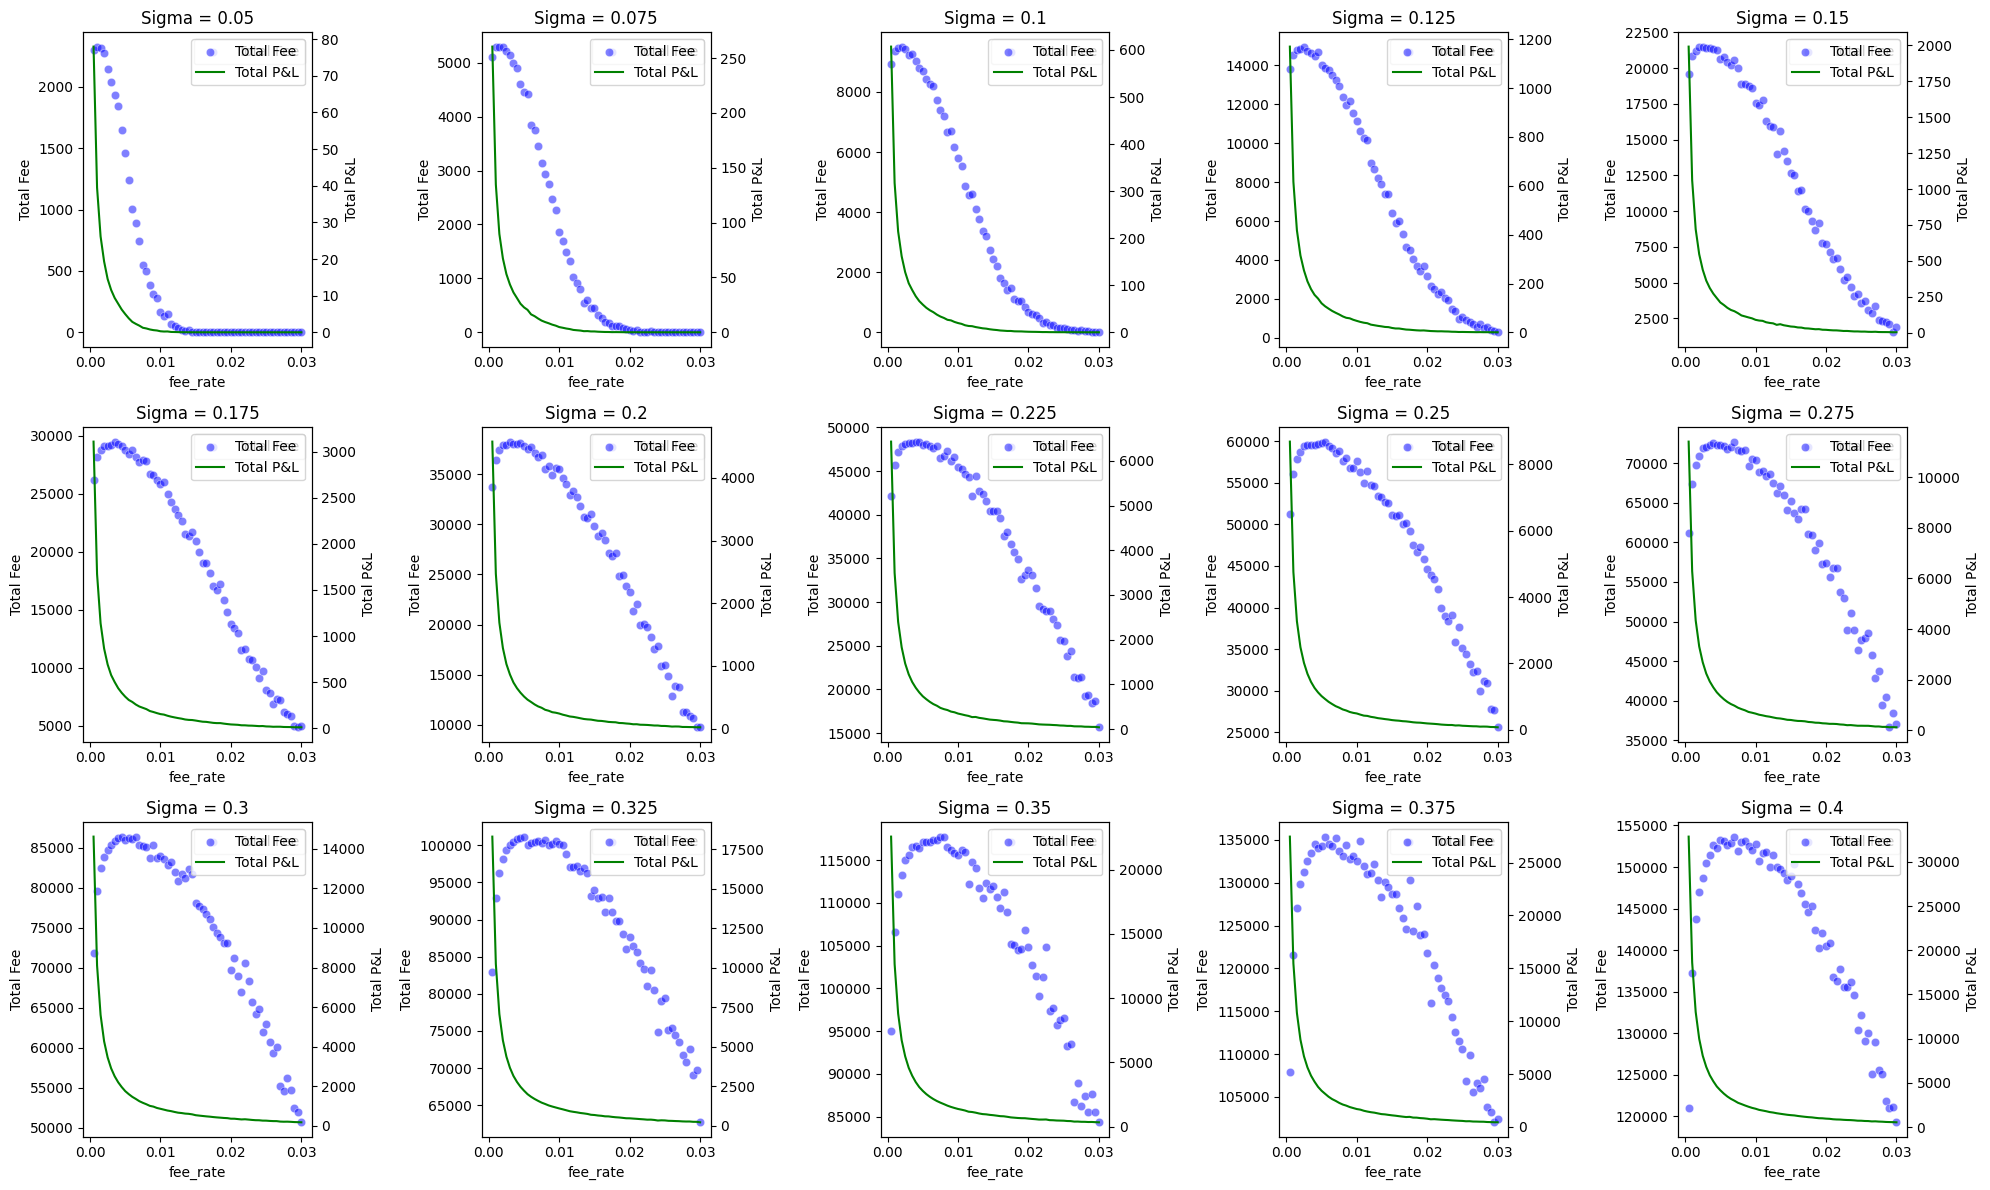

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unique sigma values
sigma_values = results.sigma.unique()
print(sigma_values)

# Create a 3x5 grid for the subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Adjust figure size as needed

for i, sigma in enumerate(sigma_values):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    
    # Filter data for the current sigma
    df = results[results.sigma == sigma]
    # Group by fee_rate and calculate the mean of total_fee and total_pnl
    grouped_df = df.groupby('fee_rate').agg({'total_fee': 'mean', 'total_pnl': 'mean'}).reset_index()
    
    # Scatter plot for total_fee
    sns.scatterplot(x='fee_rate', y='total_fee', data=grouped_df, ax=ax, color='blue', alpha=0.5, label="Total Fee")
    ax.set_ylabel('Total Fee')
    
    # Line plot for total_pnl on the secondary y-axis
    ax2 = ax.twinx()
    sns.lineplot(x='fee_rate', y='total_pnl', data=grouped_df, ax=ax2, color='green', label="Total P&L")
    ax2.set_xlabel('Fee Rate')
    ax2.set_ylabel('Total P&L')
    ax.set_title(f'Sigma = {sigma}')
    
    # Combine legends from both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


[0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325
 0.35  0.375 0.4  ]


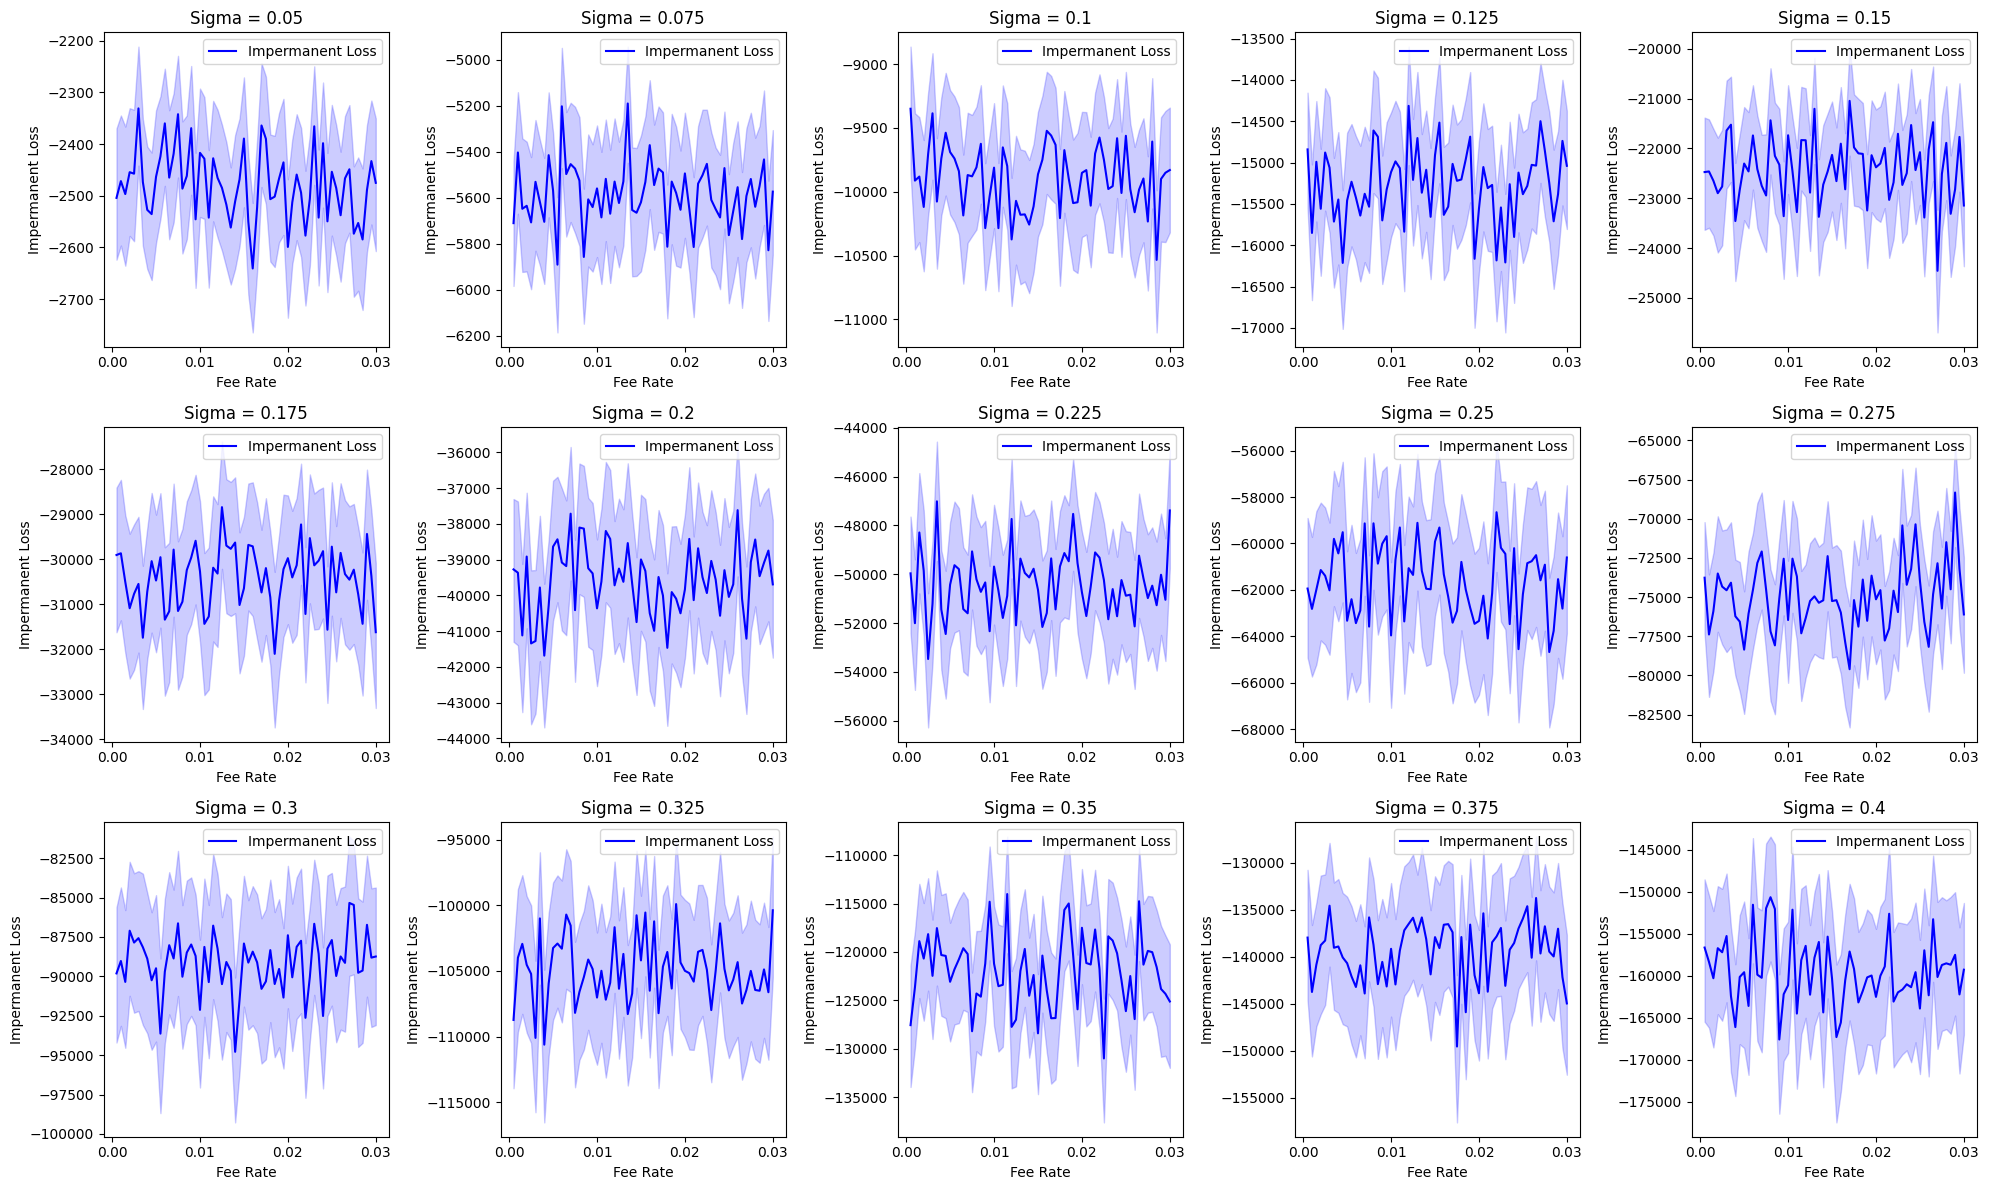

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unique sigma values
sigma_values = results.sigma.unique()
print(sigma_values)

# Create a 3x5 grid for the subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Adjust figure size as needed

for i, sigma in enumerate(sigma_values):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    
    # Filter data for the current sigma
    df = results[results.sigma == sigma]
    # Group by fee_rate and calculate the mean of impermanent_loss
    
    # Line plot for impermanent loss
    sns.lineplot(x='fee_rate', y='impermanent_loss', data=df, ax=ax, label='Impermanent Loss', color='blue')
    
    # Set labels and title for each subplot
    ax.set_xlabel('Fee Rate')
    ax.set_ylabel('Impermanent Loss')
    ax.set_title(f'Sigma = {sigma}')
    ax.legend(loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


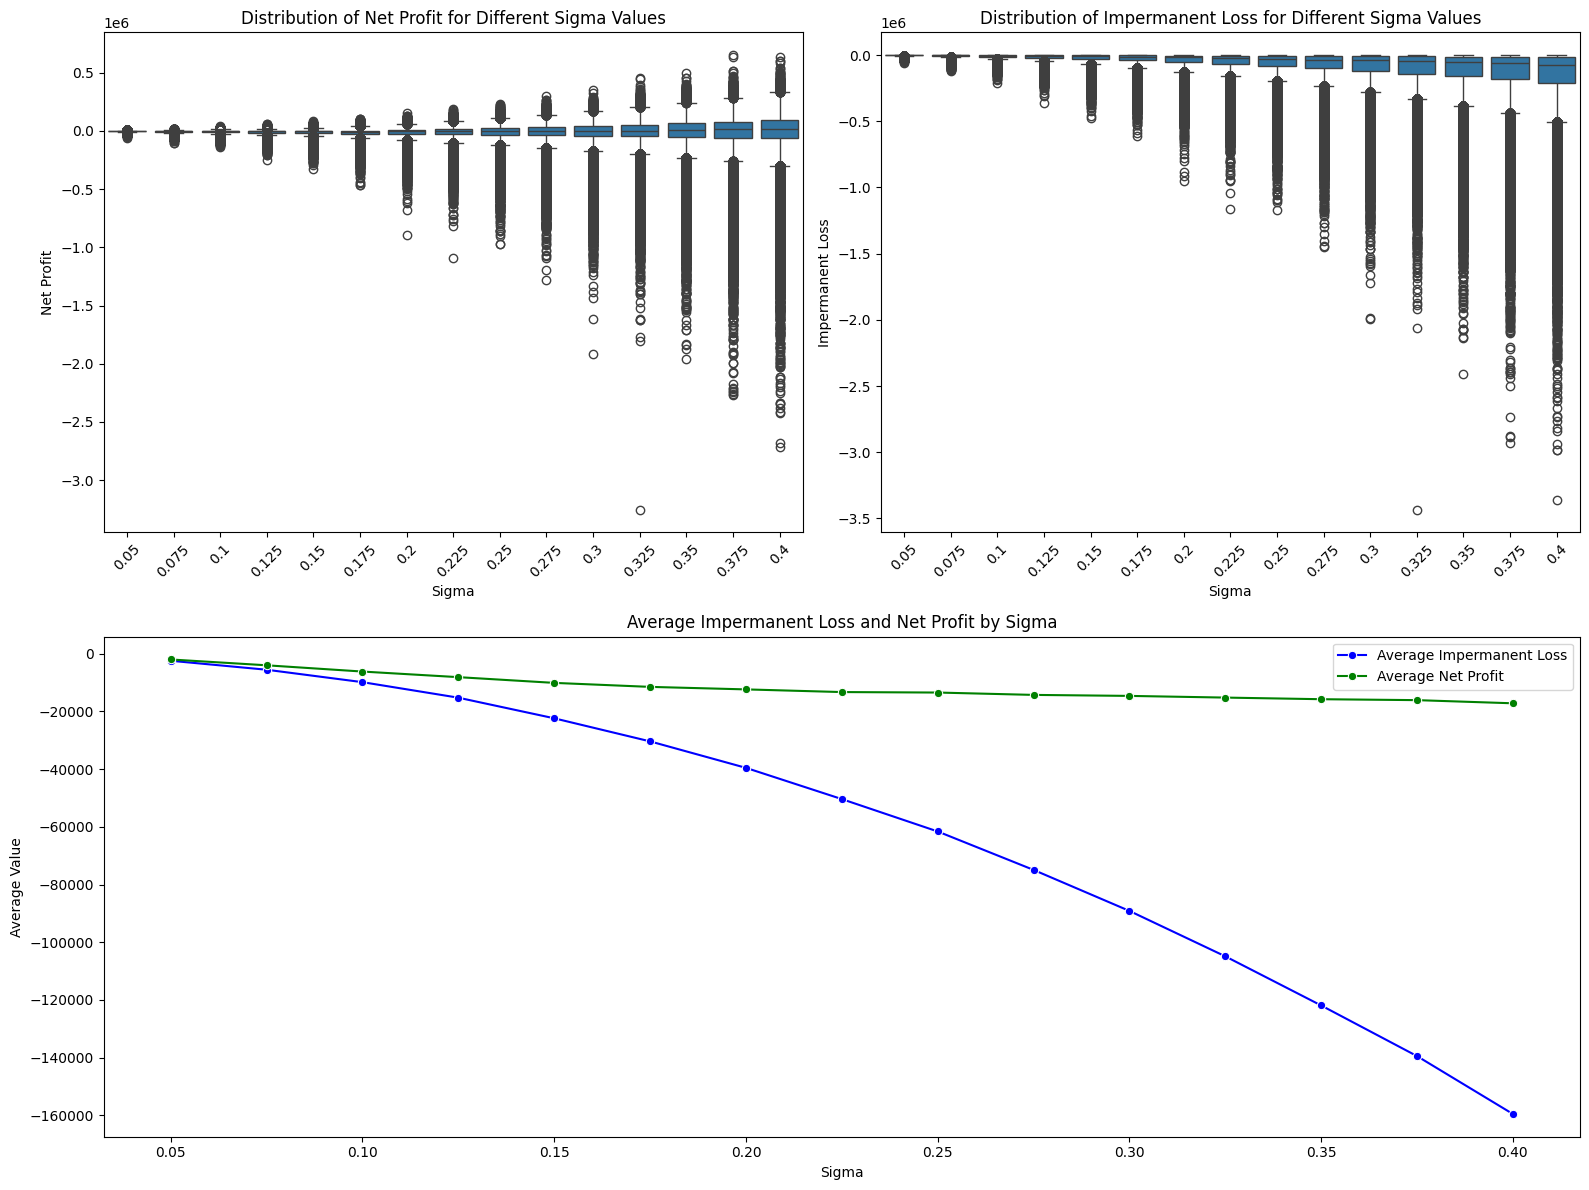

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Calculate average impermanent loss and net profit for each sigma
avg_metrics = results.groupby('sigma').agg({
    'impermanent_loss': 'mean',
    'net_profit': 'mean'
}).reset_index()

# Set up the figure with GridSpec to control the layout
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, height_ratios=[1, 1])  # 2 rows, with the bottom row larger

# Boxplot for net profit in the top-left
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(x='sigma', y='net_profit', data=results, ax=ax1)
ax1.set_xlabel('Sigma')
ax1.set_ylabel('Net Profit')
ax1.set_title('Distribution of Net Profit for Different Sigma Values')
ax1.tick_params(axis='x', rotation=45)

# Boxplot for impermanent loss in the top-right
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(x='sigma', y='impermanent_loss', data=results, ax=ax2)
ax2.set_xlabel('Sigma')
ax2.set_ylabel('Impermanent Loss')
ax2.set_title('Distribution of Impermanent Loss for Different Sigma Values')
ax2.tick_params(axis='x', rotation=45)

# Line plot for average impermanent loss and net profit on the bottom, spanning both columns
ax_combined = fig.add_subplot(gs[1, :])  # Span across both columns in the second row
sns.lineplot(x='sigma', y='impermanent_loss', data=avg_metrics, color='blue', marker='o', label='Average Impermanent Loss', ax=ax_combined)
sns.lineplot(x='sigma', y='net_profit', data=avg_metrics, color='green', marker='o', label='Average Net Profit', ax=ax_combined)

# Set labels and title for the line plot
ax_combined.set_xlabel('Sigma')
ax_combined.set_ylabel('Average Value')
ax_combined.set_title('Average Impermanent Loss and Net Profit by Sigma')
ax_combined.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## Heatmap of Positive Net Profit (%) for Each Combination of Fee Rate and Sigma

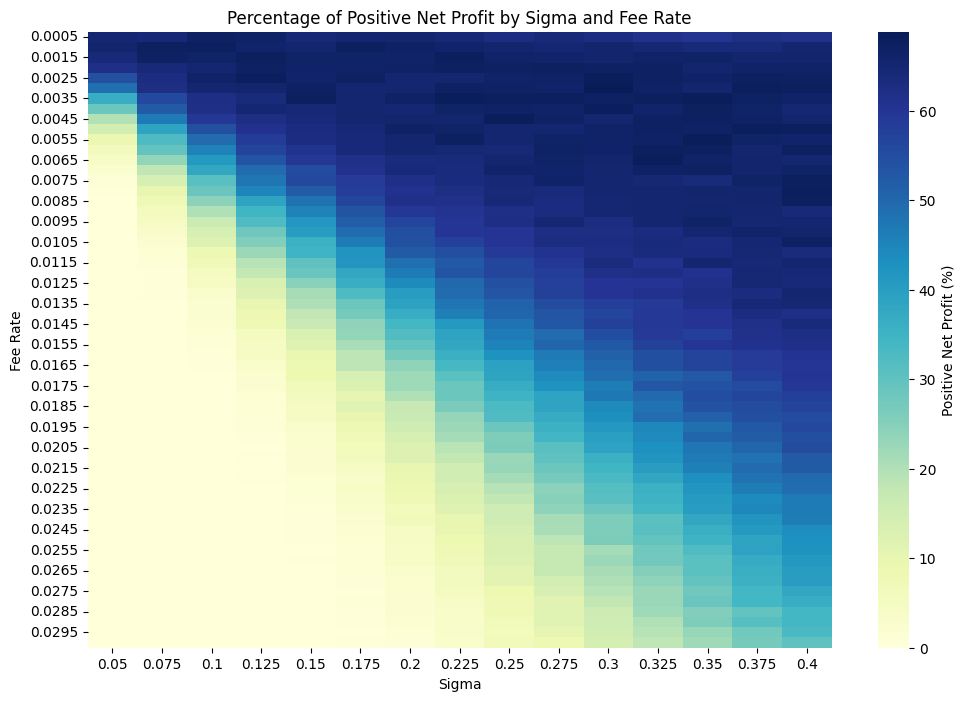

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy the data
df = results.copy()

# Calculate the percentage of positive net profit for each sigma and fee_rate combination
positive_ratio_df = df.groupby(['sigma', 'fee_rate']).apply(
    lambda x: (x['net_profit'] > 0).mean() * 100  # Convert to percentage
).reset_index(name='positive_net_profit_percentage')

# Pivot the data to create a matrix for the heatmap
heatmap_data = positive_ratio_df.pivot(index='fee_rate', columns='sigma', values='positive_net_profit_percentage')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Positive Net Profit (%)'})
plt.xlabel('Sigma')
plt.ylabel('Fee Rate')
plt.title('Percentage of Positive Net Profit by Sigma and Fee Rate')
plt.show()


## Heatmap of Kurtosis for Each Combination of Fee Rate and Sigma

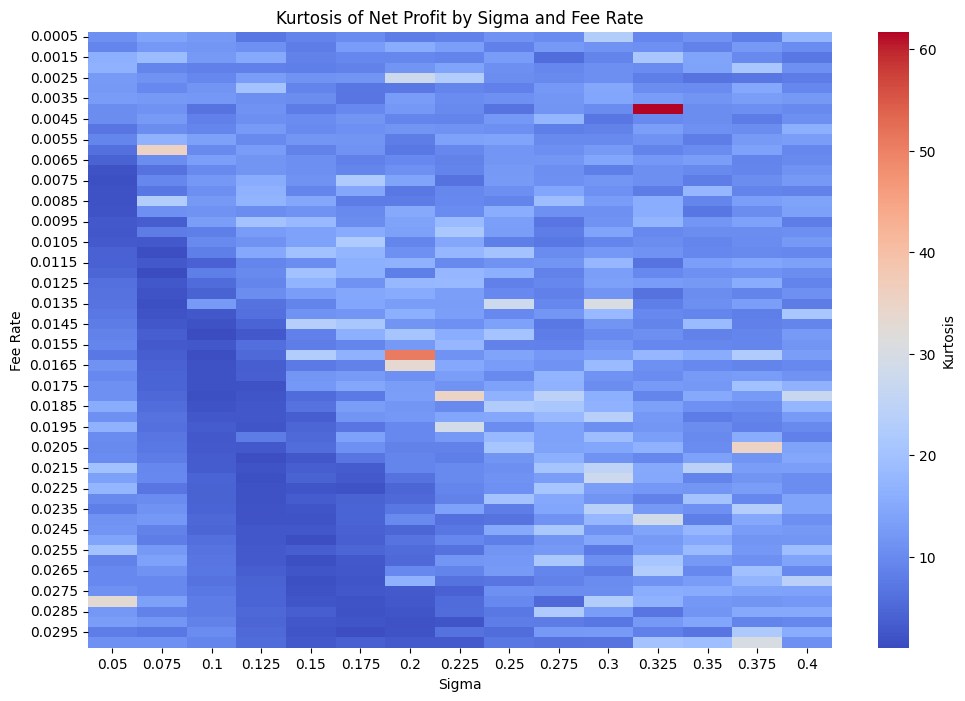

In [10]:
import pandas as pd
from scipy.stats import kurtosis

# Calculate kurtosis for each combination of sigma and fee_rate
kurtosis_df = df.groupby(['sigma', 'fee_rate'])['net_profit'].apply(lambda x: kurtosis(x)).reset_index(name='kurtosis')

# Pivot the data for the heatmap
kurtosis_heatmap_data = kurtosis_df.pivot(index='fee_rate', columns='sigma', values='kurtosis')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(kurtosis_heatmap_data, annot=False, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Kurtosis'})
plt.xlabel('Sigma')
plt.ylabel('Fee Rate')
plt.title('Kurtosis of Net Profit by Sigma and Fee Rate')
plt.show()


## Heatmap of Skewness for Each Combination of Fee Rate and Sigma

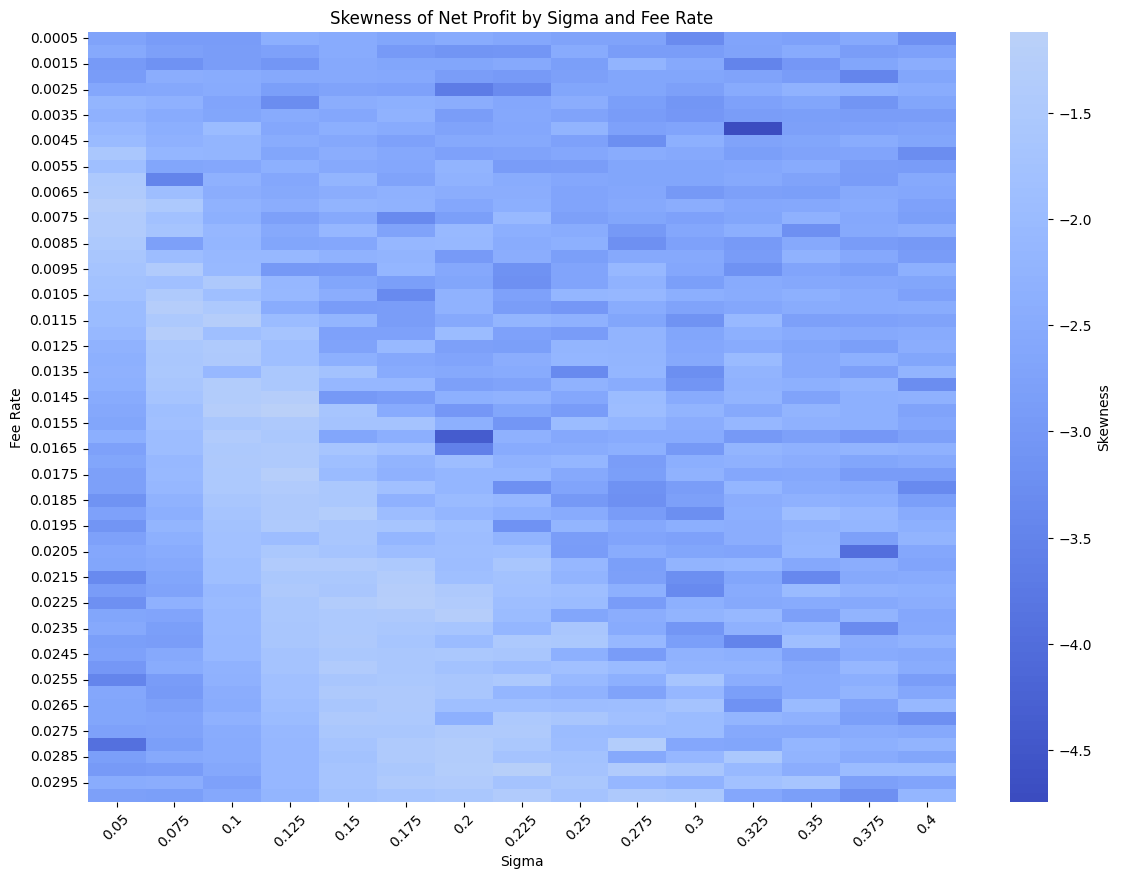

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Calculate skewness for each combination of sigma and fee_rate
skewness_df = results.groupby(['sigma', 'fee_rate'])['net_profit'].apply(lambda x: skew(x)).reset_index(name='skewness')

# Pivot the data for the heatmap
skewness_heatmap_data = skewness_df.pivot(index='fee_rate', columns='sigma', values='skewness')

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(skewness_heatmap_data, annot=False, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={'label': 'Skewness'})
plt.xlabel('Sigma')
plt.ylabel('Fee Rate')
plt.title('Skewness of Net Profit by Sigma and Fee Rate')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


## Heatmap for Difference Between Mean and Median


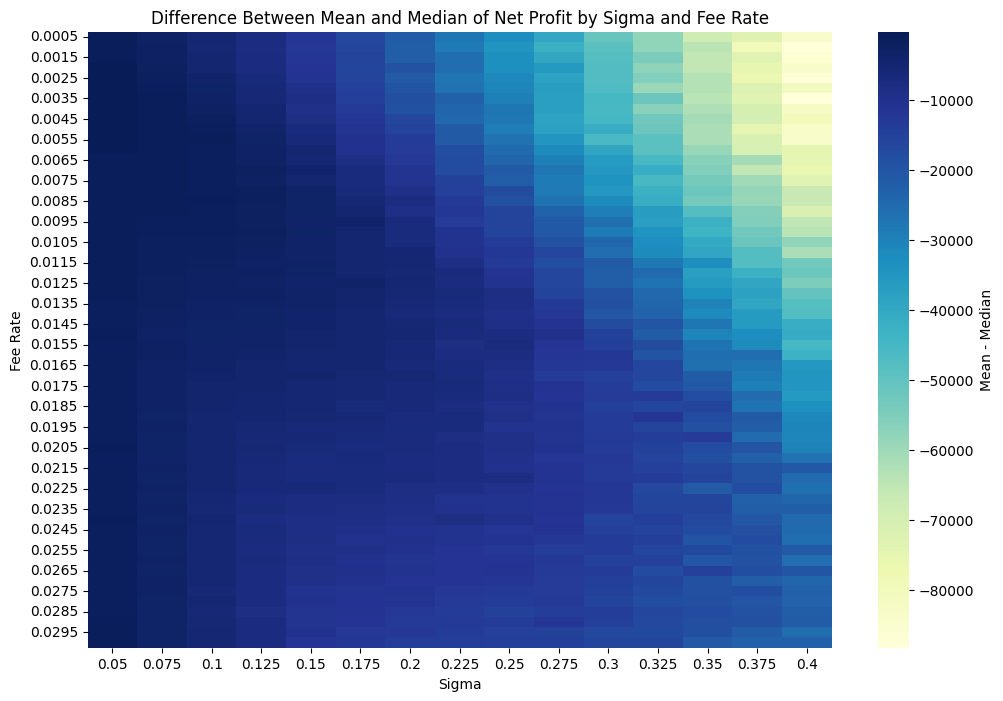

In [22]:
# Calculate mean and median difference for each combination of sigma and fee_rate
df = results.copy()
mean_median_diff_df = df.groupby(['sigma', 'fee_rate'])['net_profit'].apply(lambda x: x.mean() - x.median()).reset_index(name='mean_median_difference')

# Pivot the data for the heatmap
mean_median_diff_heatmap_data = mean_median_diff_df.pivot(index='fee_rate', columns='sigma', values='mean_median_difference')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mean_median_diff_heatmap_data, annot=False, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean - Median'})
plt.xlabel('Sigma')
plt.ylabel('Fee Rate')
plt.title('Difference Between Mean and Median of Net Profit by Sigma and Fee Rate')
plt.show()


## Expected Net Profit Given Positive Net Profit


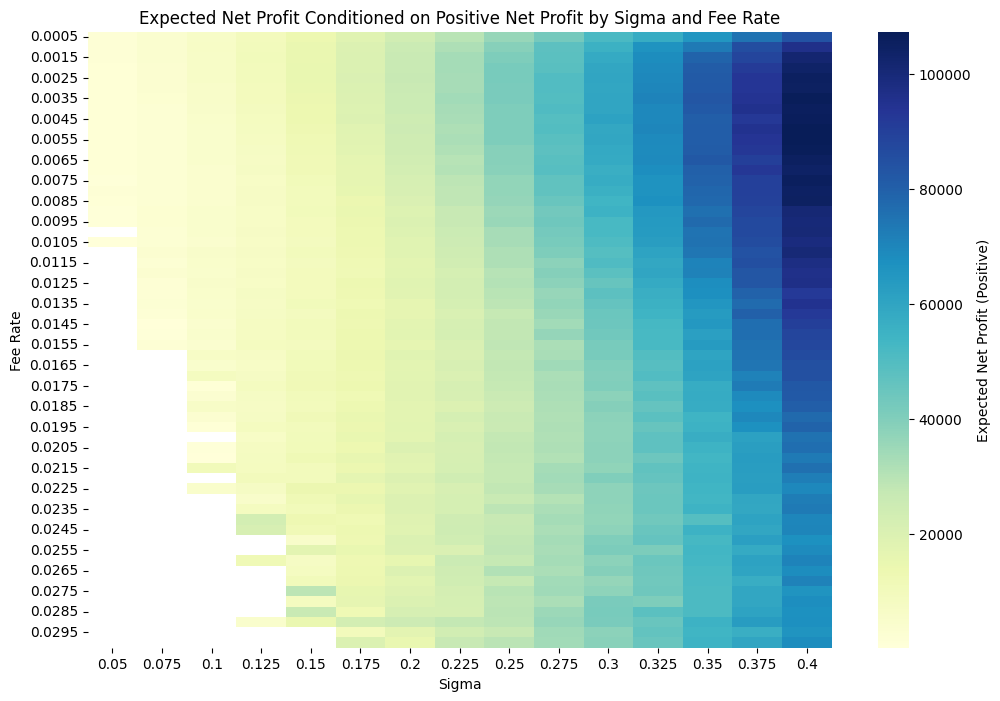

In [21]:
# Calculate expected net profit for each combination of sigma and fee_rate, conditioned on positive net profit
df = results.copy()
expected_positive_profit_df = df[df['net_profit'] > 0].groupby(['sigma', 'fee_rate'])['net_profit'].mean().reset_index(name='expected_net_profit_positive')

# Pivot the data for the heatmap
expected_positive_profit_heatmap_data = expected_positive_profit_df.pivot(index='fee_rate', columns='sigma', values='expected_net_profit_positive')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(expected_positive_profit_heatmap_data, annot=False, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Expected Net Profit (Positive)'})
plt.xlabel('Sigma')
plt.ylabel('Fee Rate')
plt.title('Expected Net Profit Conditioned on Positive Net Profit by Sigma and Fee Rate')
plt.show()


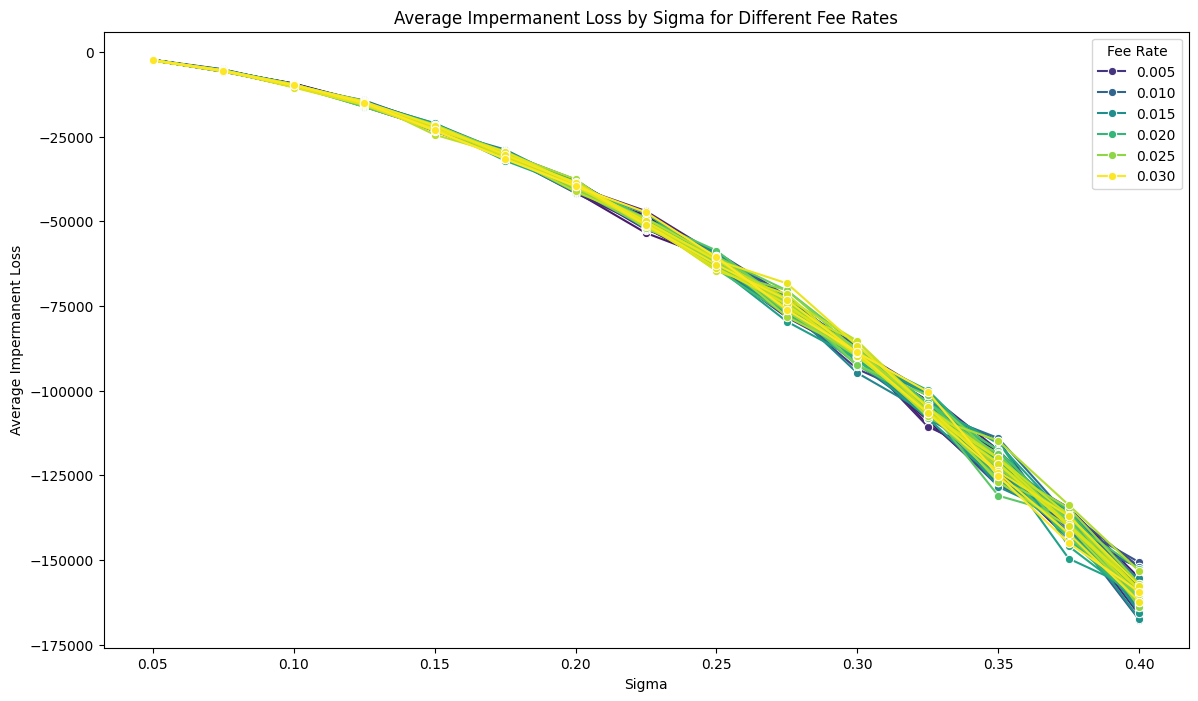

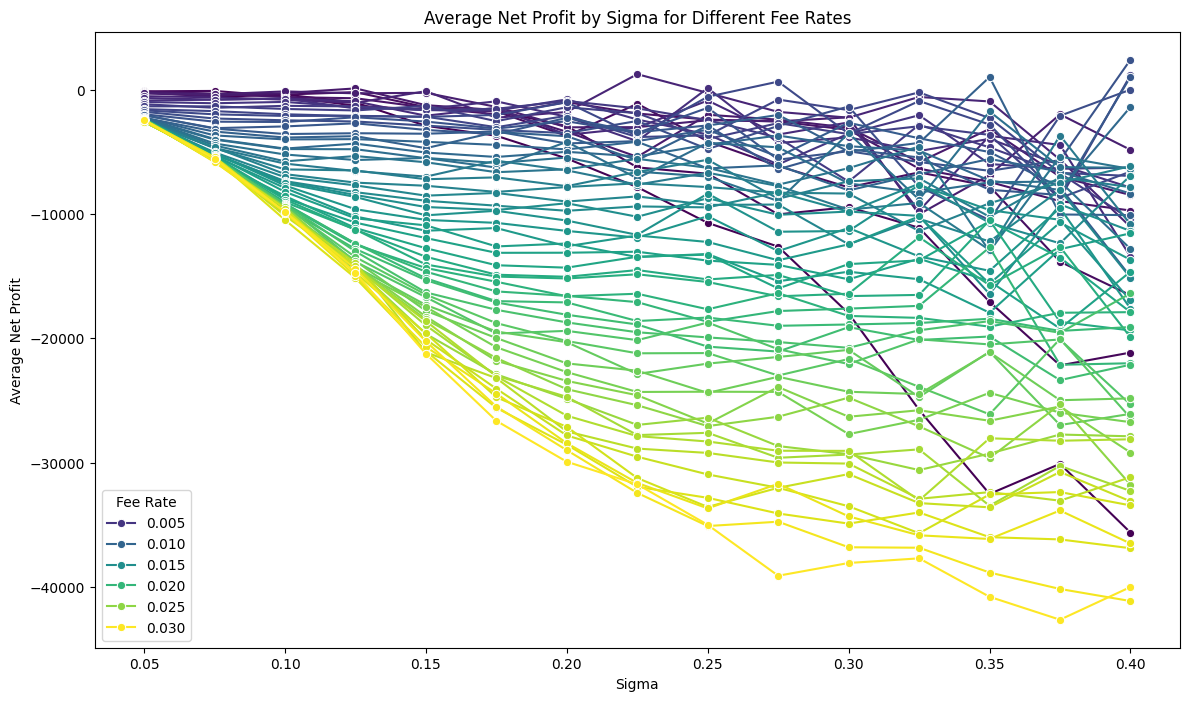

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average impermanent loss and net profit for each sigma and fee_rate combination
avg_metrics = results.groupby(['sigma', 'fee_rate']).agg({
    'impermanent_loss': 'mean',
    'net_profit': 'mean'
}).reset_index()

# Set up the figure
plt.figure(figsize=(14, 8))

# Plot average impermanent loss for each fee rate using hue for color distinction
sns.lineplot(x='sigma', y='impermanent_loss', hue='fee_rate', data=avg_metrics, marker='o', palette='viridis')
plt.xlabel('Sigma')
plt.ylabel('Average Impermanent Loss')
plt.title('Average Impermanent Loss by Sigma for Different Fee Rates')
plt.legend(title='Fee Rate')
plt.show()

# Set up a separate figure for net profit
plt.figure(figsize=(14, 8))

# Plot average net profit for each fee rate using hue for color distinction
sns.lineplot(x='sigma', y='net_profit', hue='fee_rate', data=avg_metrics, marker='o', palette='viridis')
plt.xlabel('Sigma')
plt.ylabel('Average Net Profit')
plt.title('Average Net Profit by Sigma for Different Fee Rates')
plt.legend(title='Fee Rate')
plt.show()


In [14]:
# count fee rate == 0.03, sigma == 0.4, how many net profit > 0
df = results.copy()
count = df[(df['fee_rate'] == 0.03) & (df['sigma'] == 0.4) & (df['net_profit'] > 0)].shape[0]
total = df[(df['fee_rate'] == 0.03) & (df['sigma'] == 0.4)].shape[0]
percentage = count / total * 100
print(f"Percentage of positive net profit for fee_rate=0.03 and sigma=0.4: {percentage:.2f}%")
print(f"total count: {total}")  
print(f"count: {count}")

# calculate the 95 CI for net profit for fee rate == 0.03 and sigma == 0.4
df = results.copy()
df = df[(df['fee_rate'] == 0.03) & (df['sigma'] == 0.4)]
mean = df['net_profit'].mean()
std = df['net_profit'].std()
n = df.shape[0]
z = 1.96  # 95% confidence interval
ci = z * (std / np.sqrt(n))
lower_bound = mean - ci
upper_bound = mean + ci
print(f"95% Confidence Interval for Net Profit (Fee Rate = 0.03, Sigma = 0.4): ({lower_bound:.2f}, {upper_bound:.2f})")
print(f"mean: {mean}")


Percentage of positive net profit for fee_rate=0.03 and sigma=0.4: 30.13%
total count: 3000
count: 904
95% Confidence Interval for Net Profit (Fee Rate = 0.03, Sigma = 0.4): (-44541.69, -35437.03)
mean: -39989.3598363098


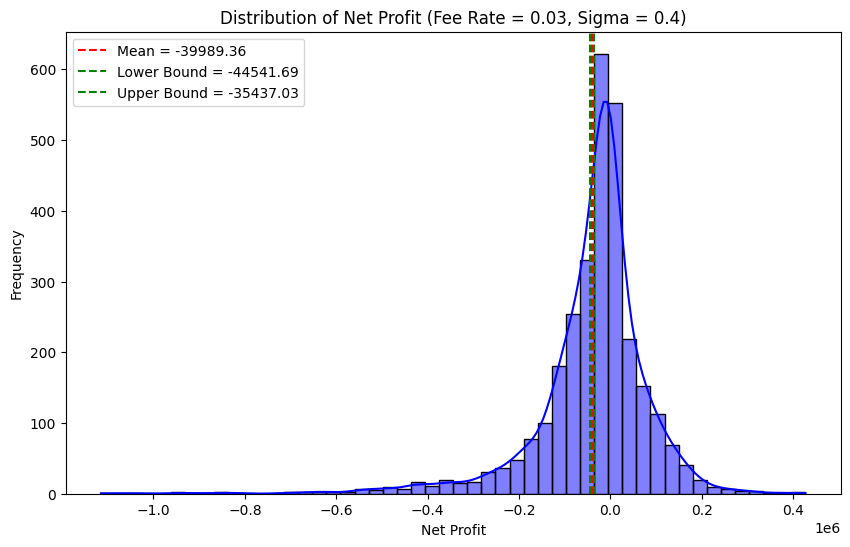

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for the specific fee rate and sigma
df_filtered = results[(results['fee_rate'] == 0.03) & (results['sigma'] == 0.4)]

# Set up the figure
plt.figure(figsize=(10, 6))

# Draw the histogram
sns.histplot(df_filtered['net_profit'], bins=50, kde=True, color='blue')

# Add labels and title
plt.xlabel('Net Profit')
plt.ylabel('Frequency')
plt.title('Distribution of Net Profit (Fee Rate = 0.03, Sigma = 0.4)')
plt.axvline(df_filtered['net_profit'].mean(), color='red', linestyle='--', label=f'Mean = {df_filtered["net_profit"].mean():.2f}')
# add the 95% CI
plt.axvline(lower_bound, color='green', linestyle='--', label=f'Lower Bound = {lower_bound:.2f}')
plt.axvline(upper_bound, color='green', linestyle='--', label=f'Upper Bound = {upper_bound:.2f}')
plt.legend()

# Show the plot
plt.show()
